In [7]:
LOAD = False

# reload module each time cell is run
%load_ext autoreload
%autoreload 2

import numpy as np
# pip install numba
from numba import njit, prange, boolean, int32, double
from numba.experimental import jitclass
import time

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# tools
from tools import linear_interp # for linear interpolation
from tools import misc # various tools
from tools.ConsumptionSavingModel import ConsumptionSavingModel # baseline model classes

# solution and plot routines
import solve_GP2002 as gp
import tools.plot as plot

from tools import SimulatedMinimumDistance as SMD

In [8]:
add_str = ''
est_par = ("beta","rho")
est_par_tex = (r'$\hat{\beta}$',r'$\hat{\rho}$')

# choose gamma (fixed)
fixed_par = ('sigma_perm','sigma_trans','p','r','mu_a_init','sigma_a_init')
fixed_par_tex = (r'$\sigma_{n}$',r'$\sigma_{u}$',r'$p$',r'$r$',r'$\tilde{\omega}_{26}$',r'$\sigma_{\omega_{26}}$')

In [9]:
# moment function
@njit ## decorator to speed up computation
def mom_fun(data):
    return np.log(data.C_avg)

# load data
consumption,income,weight = gp.load_data() ## from load_data() function in "solve_GP2002.py"
mom_data = np.log(consumption)
theta0 = [0.944, 1.860] 
## Prof.Thomas re-estimate β and ρ using his implementation while fixing γ_0=0.0015 and γ_1=0.071 to the estimated values in G&P. 
## T use the re-estimated model throughout with β^ = 0.944 and ρ^ = 1.860.


In [10]:
consumption,income,weight

(array([20.34644, 20.60855, 20.55339, 20.56867, 20.83285, 20.96067,
        21.56672, 21.45977, 21.28263, 22.12791, 21.92988, 21.46042,
        21.61997, 22.35983, 22.10736, 23.01614, 22.42462, 22.87131,
        23.25059, 23.83926, 22.80364, 22.54849, 23.35426, 22.35936,
        21.65177, 21.38305, 21.78746, 21.45416, 20.35878, 19.84286,
        20.31113, 20.35393, 19.33162, 19.08218, 17.61398, 19.07707,
        18.32134, 18.50198, 17.78804, 18.20176]),
 array([18.69096, 19.16394, 19.62111, 20.06487, 20.49721, 20.91971,
        21.33354, 21.73935, 22.13736, 22.52725, 22.90831, 23.27932,
        23.63863, 23.98427, 24.31383, 24.62466, 24.91386, 25.17837,
        25.41505, 25.62079, 25.79254, 25.92747, 26.02309, 26.0773 ,
        26.08844, 26.0556 , 25.97838, 25.85724, 25.69343, 25.48899,
        25.24682, 24.97068, 24.66515, 24.33561, 23.98818, 23.62962,
        23.26747, 22.90967, 22.56494, 22.24254]),
 array([[3.6872008, 0.       , 0.       , ..., 0.       , 0.       ,
         0.    

In [34]:
omega = np.linalg.inv(weight) ## a diagonal matrix with the variance of the empirical moments on the diagonal.
omega

array([[0.27120845, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.26281237, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.28168668, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.28310876, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.28334603,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.29233049]])

In [ ]:
###
    def std_error(self,theta,est_par,W,Omega,Nobs,Nsim,step=1.0e-4,*args):
        ''' Calculate standard errors '''

        # 1. numerical gradient of moment function wrt theta. 
        self.grad = self.num_grad_moms(theta,est_par,W,*args)

        # 2. asymptotic standard errors [using Omega: V(mom_data_i). If bootstrapped, remember to multiply by Nobs]
        GW  = np.transpose(self.grad) @ W
        GWG = GW @ self.grad

        Avar = np.linalg.inv(GWG) @ ( GW @ Omega @ np.transpose(GW) ) @ np.linalg.inv(GWG)
        fac  = (1.0 + 1.0/Nsim)/Nobs # Nsim: number of simulated observations, Nobs: number of observations in data
        self.std = np.sqrt( fac*np.diag(Avar) )
###

In [41]:
# smd_base.sensitivity(theta_base,est_par,weight,fixed_par,do_robust=do_robust)
# sensitivity(self,theta,est_par,W,fixed_par_str=None,step=1.0e-7,grad=None,do_robust=False,*args):

Nobs = 38691
Nsim = 50000 ## doesn't make a big difference

smd_base.std_error(theta_base, est_par, weight, omega, Nobs, Nsim, step=1.0e-4)
smd_base.std

array([0.00043366, 0.0336196 ])

In [42]:
GW = np.transpose(smd_base.grad) @ weight
GWG = GW @ smd_base.grad
Avar = np.linalg.inv(GWG) @ ( GW @ omega @ np.transpose(GW)) @ np.linalg.inv(GWG)
Avar

array([[ 7.27622139e-03, -5.42340081e-01],
       [-5.42340081e-01,  4.37307005e+01]])

In [12]:
# Estimate the baseline model
model_base = gp.GP2002()
model_base.draw_random()

In [14]:
smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=False,options={'disp':True})
if LOAD:
    smd_base.est = theta0
else:
    smd_base.estimate(theta0,est_par,weight)

Optimization terminated successfully.
         Current function value: 0.540269
         Iterations: 31
         Function evaluations: 62


In [15]:
theta_base = smd_base.est

In [16]:
theta0

[0.944, 1.86]

In [17]:
# update model parameters
for p in range(len(est_par)):
    setattr(model_base.par,est_par[p],theta_base[p]) 

In [18]:
# solve and simulate model
model_base.solve() 
model_base.draw_random()
model_base.simulate()

In [19]:
theta_base

array([0.94414316, 1.86037514])

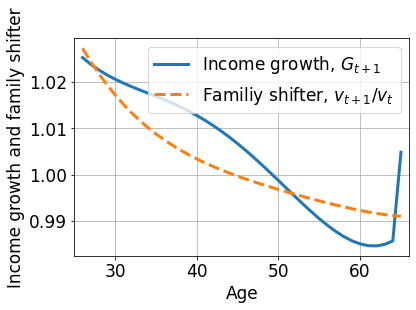

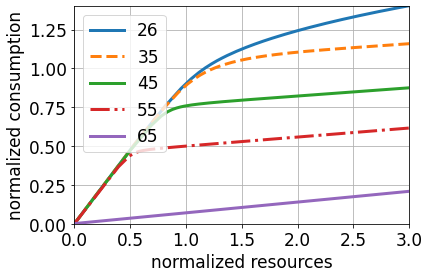

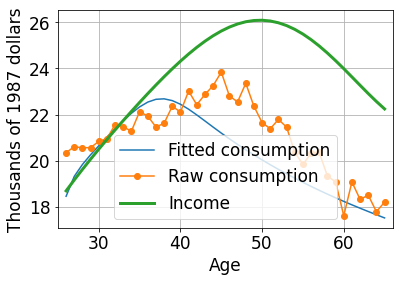

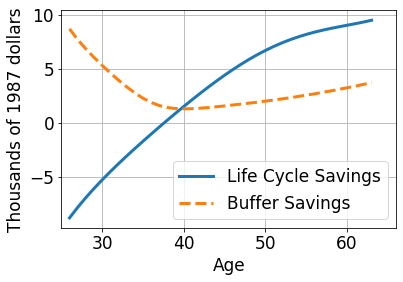

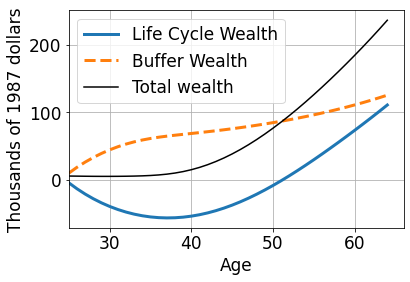

In [20]:
# Construct baseline plots 
plot.cali(model_base)
plot.fig1(model_base,add_str)
plot.fig5(model_base,consumption,income,add_str)
plot.fig7(theta_base,est_par,add_str)